In [1]:
# Library Imports 
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
importlib.reload(mf)
from collections import defaultdict

In [2]:
data_path = "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/"
figure_save_path="/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/Thesis Figures and Diagrams/Figures/MyResults"
data_file ="data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-07-47_freq_195.11847_rng_36.6852_gain_30_fld_0.0.csv"

## Functions ## 

In [3]:
def read_B_field(file_name):
    match = re.search(r'fld_([0-9.]+)', file_name)
    if match: 
        
        b_field = float(match.group(1).strip("."))
        return b_field
    else: 
        print("Error: field value not found in filename.")

## Single Spectrum ## 

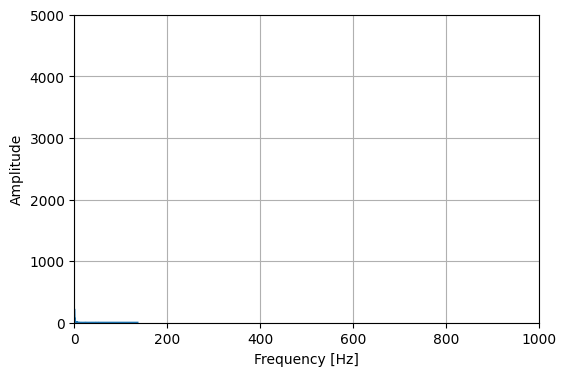

<Figure size 640x480 with 0 Axes>

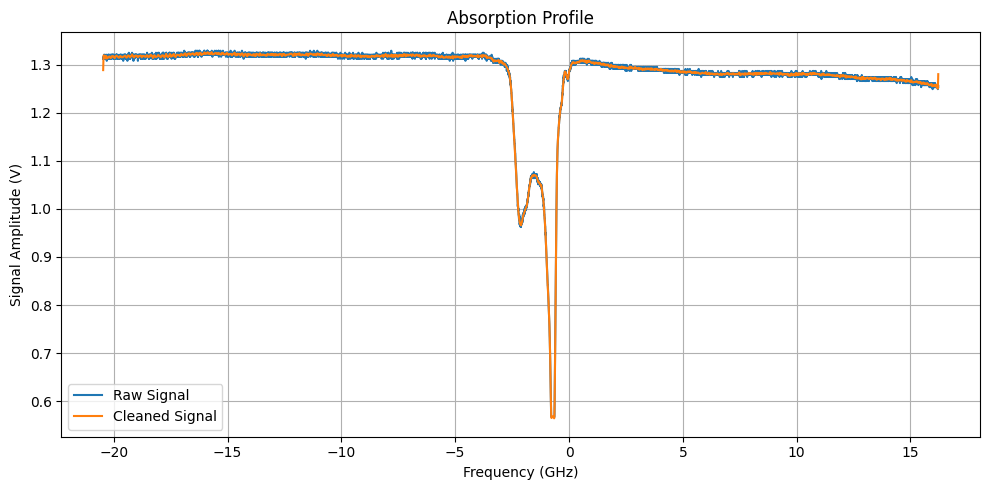

In [4]:

# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9
## Low Pass Band Filter ## 20 Hz. 
cleaned = mf.low_pass_band_filter_fft(20,freq_axis_GHz,voltage,plot_check=True)

# Plot absorption profile
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freq_axis_GHz, voltage, label='Raw Signal')
ax.plot(freq_axis_GHz, cleaned, label='Cleaned Signal')
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal Amplitude (V)")
ax.set_title("Absorption Profile")
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

## 2D Colour Map ## 

In [63]:
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    #voltage = mf.low_pass_band_filter_fft(20,freq_axis_GHz,voltage,plot_check=False)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]


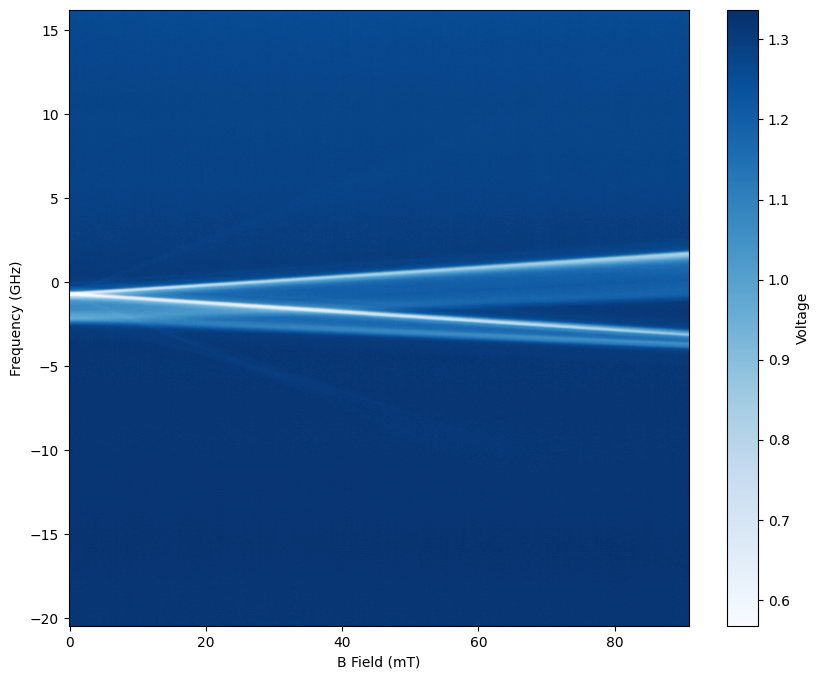

In [109]:
fig, ax = plt.subplots(figsize=(10,8))
#c= ax.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
c=ax.pcolormesh(fields * 1000, freq_axis_GHz, voltages.T, shading='auto', cmap='Blues')  # Alternative plot
#ax.set_xlim([-10, 10])
#ax.set_ylim([80, 90])  # Uncomment and set limits if needed
fig.colorbar(c, ax=ax, label="Voltage")
ax.set_xlabel("B Field (mT)")
ax.set_ylabel("Frequency (GHz)")
plt.show()


## Linear Fitting and Graphing Peak Picking ## 

In [ ]:


# Load data for each peak
peak_paths = {
    "A": "data_optics/peak_picking_data/2025_04_07_16_15_25_absorption_peaks_2025-03-25_peak_A.csv",
    "B": "data_optics/peak_picking_data/2025_04_07_16_38_22_absorption_peaks_2025-03-25_peak_B.csv",
    "C": "data_optics/peak_picking_data/2025_04_07_16_42_53_absorption_peaks_2025-03-25_peak_C.csv",
    "D": "data_optics/peak_picking_data/2025_04_07_16_47_17_absorption_peaks_2025-03-25_peak_D_fix.csv",
    "E": "data_optics/peak_picking_data/2025_04_07_16_53_26_absorption_peaks_2025-03-25_peak_E.csv",
    "F": "data_optics/peak_picking_data/2025_04_07_16_58_55_absorption_peaks_2025-03-25_peak_F.csv"
}

peak_data = {}
slopes = {}
extrap_fields=np.arange(0, int(fields[-1]*1000),step=1)

# Load each peak data into a dictionary and calculate the slope and R^2
for peak, path in peak_paths.items():
    data = pd.read_csv(path)
    freq = data['Frequency (GHz)'].values
    print(freq)
    b_field = data['B Field (mT)'].values

    # Linear fit
    fit = np.polyfit(b_field, freq, 1)  # Slope and intercept
    slope = fit[0]
    intercept = fit[1]

    # Create the polynomial function for the fit
    poly = np.poly1d(fit)

    
    # Extrapolate the fit over the entire range of the predefined fields array
    extrapolated_fit = poly(extrap_fields)

    # Calculate fitted values for the original data
    fitted_values = poly(b_field)

    # Calculate R^2
    ss_res = np.sum((freq - fitted_values) ** 2)
    ss_tot = np.sum((freq - np.mean(freq)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    slopes[peak] = (slope, intercept, r_squared)
    # Store the data and fit line
    peak_data[peak] = {
        "freq": freq,
        "b_field": b_field,
        "slope": slope,
        "r_squared": r_squared,
        "fit_line": fitted_values,
        "intercept": intercept,
        "extrapolated_fit": extrapolated_fit
    }
    print(f"Slope of Peak {peak}: {slope:.6f} GHz/mT, R²: {r_squared:.6f}, Intercept: {intercept:.6f}")


Slope of Peak A: -0.026909 GHz/mT, R²: 0.999348, Intercept: -0.675555
Slope of Peak B: 0.026532 GHz/mT, R²: 0.999257, Intercept: -0.697532
Slope of Peak C: -0.019576 GHz/mT, R²: 0.959734, Intercept: -1.941016
Slope of Peak D: 0.017369 GHz/mT, R²: 0.993734, Intercept: -2.126620
Slope of Peak E: -0.134052 GHz/mT, R²: 0.992956, Intercept: -1.302576
Slope of Peak F: 0.162016 GHz/mT, R²: 0.999220, Intercept: -0.688081


[-0.69059212 -0.69059212 -0.74266141 -0.7947307  -0.82076534 -0.87283463
 -0.95093856 -0.95093856 -1.00300785 -1.0290425  -1.10714643 -1.15921572
 -1.15921572 -1.21128501 -1.23731965 -1.28938894 -1.34145823 -1.36749287
 -1.39352752 -1.44559681 -1.52370074 -1.52370074 -1.57577003 -1.60180467
 -1.65387396 -1.6799086  -1.75801254 -1.75801254 -1.81008183 -1.86215112
 -1.86215112 -1.94025505 -1.99232434 -2.01835898 -2.09646291 -2.09646291
 -2.1485322  -2.20060149 -2.25267078 -2.25267078 -2.30474007 -2.35680936
 -2.382844   -2.46094794 -2.46094794 -2.48698258 -2.53905187 -2.6171558
 -2.66922509 -2.66922509 -2.72129438 -2.77336367 -2.79939831 -2.79939831
 -2.8514676  -2.92957153 -2.98164082 -3.00767547 -3.00767547 -3.0857794 ]
Slope of Peak A: -0.026909 GHz/mT, R²: 0.999348, Intercept: -0.675555
[ 1.70459516  1.67856052  1.62649123  1.60045658  1.54838729  1.496318
  1.47028336  1.39217943  1.41821407  1.36614478  1.28804085  1.23597156
  1.26200621  1.18390227  1.15786763  1.10579834  1.0797

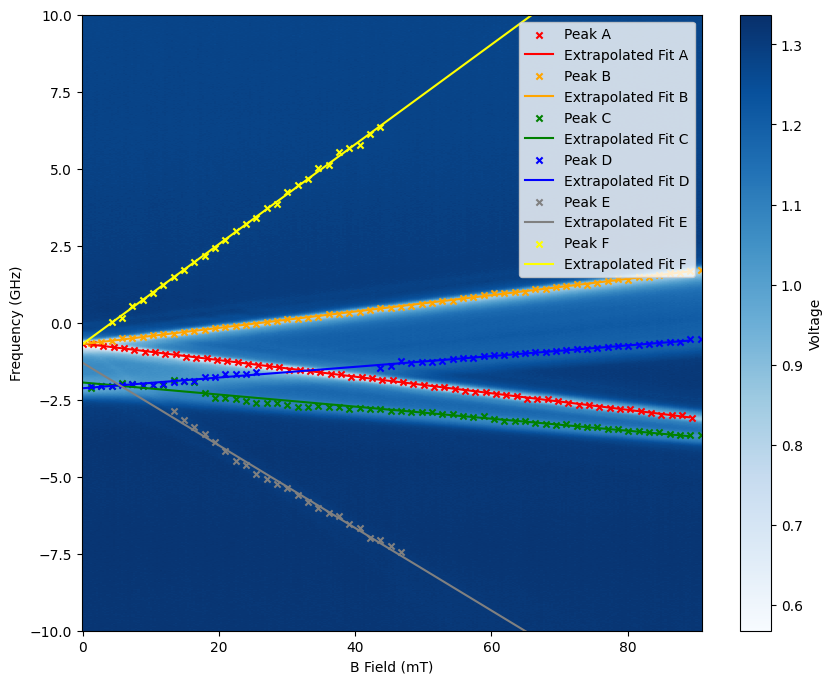

In [186]:
# Plot the data and linear fits
fig2, ax2 = plt.subplots(figsize=(10, 8))
c = ax2.pcolormesh(fields * 1000,freq_axis_GHz, voltages.T, shading='auto', cmap='Blues')
# Plot the scatter points, linear fits, and extrapolated fits for each peak
colors = ['red', 'orange', 'green', 'blue', 'grey', 'yellow']
for i, (peak, data) in enumerate(peak_data.items()):
    # Scatter plot of the original data points
    ax2.scatter(data['b_field'], data['freq'], color=colors[i], marker='x', label=f"Peak {peak}", s=20)

    # Plot the fitted line within the original data range
    #ax2.plot(data['b_field'], data['fit_line'], color=colors[i], linestyle='--', label=f"Fit {peak} (R²={data['r_squared']:.3f})")

    # Plot the extrapolated fit over the entire fields range
    ax2.plot(extrap_fields, data['extrapolated_fit'], color=colors[i], label=f"Extrapolated Fit {peak}")

# Add labels and legend
fig2.colorbar(c, ax=ax2, label="Voltage")
ax2.set_ylim([-10,10])
ax2.set_xlabel("B Field (mT)")
ax2.set_ylabel("Frequency (GHz)")
ax2.legend()

KeyError: 'freq'

Slope of deltaE = F-A_ground_o: 0.188925 GHz/mT, Intercept: -0.012526
Slope of deltaE = B-E_ground_o: 0.160584 GHz/mT, Intercept: 0.605044
Slope of deltaE = A-E_excited_o: 0.107143 GHz/mT, Intercept: 0.627021
Slope of deltaE = F-B_excited_o: 0.135484 GHz/mT, Intercept: 0.009451


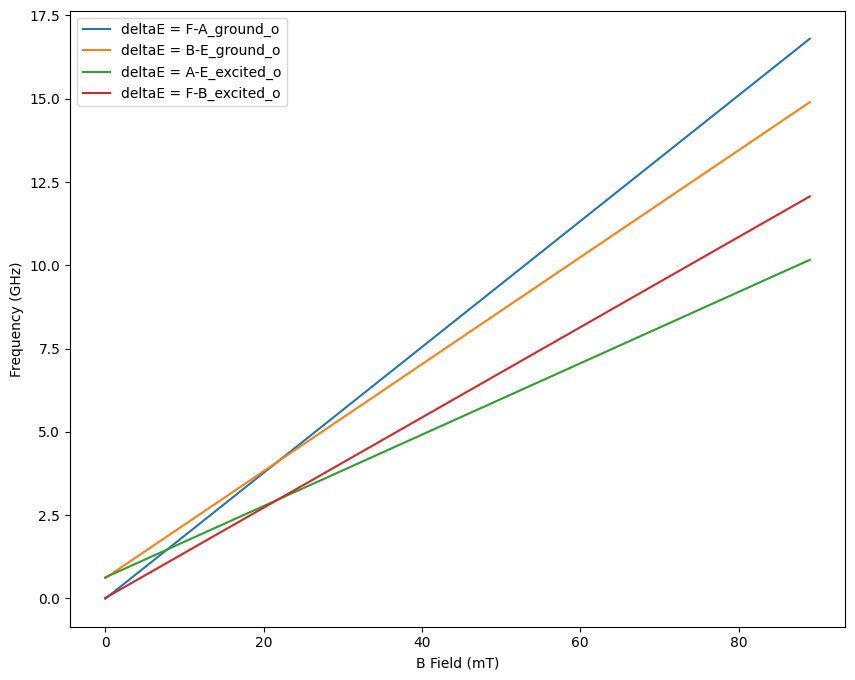

In [168]:
fig3, ax3 = plt.subplots(figsize=(10, 8))

# Get the extrapolated fit lines from the peak data
e2e_line = np.array(peak_data["A"]["extrapolated_fit"])
g2e_line = np.array(peak_data["F"]["extrapolated_fit"])
e2g_line = np.array(peak_data["E"]["extrapolated_fit"])
g2g_line = np.array(peak_data["B"]["extrapolated_fit"])

# Calculate the difference between lines
delta_E_abs_F_A = g2e_line - e2e_line
delta_E_abs_B_E = g2g_line - e2g_line
delta_E_abs_A_E = e2e_line - e2g_line
delta_E_abs_F_B = g2e_line - g2g_line

# Define a function to calculate the slope and plot the fitted line
def calculate_slope(x, y, label):
    # Perform linear fit
    fit = np.polyfit(x, y, 1)  # Degree 1 for linear fit
    slope, intercept = fit
    print(f"Slope of {label}: {slope:.6f} GHz/mT, Intercept: {intercept:.6f}")
    
    # Plot the fitted line
    y_fit = np.poly1d(fit)(x)
   #ax3.plot(x, y_fit, linestyle='--', label=f"Fit {label} (Slope={slope:.3f})")
    return slope, intercept

# Plot the delta E lines
ax3.plot(extrap_fields, delta_E_abs_F_A, label="deltaE = F-A_ground_o")
ax3.plot(extrap_fields, delta_E_abs_B_E, label="deltaE = B-E_ground_o")
ax3.plot(extrap_fields, delta_E_abs_A_E, label="deltaE = A-E_excited_o")
ax3.plot(extrap_fields, delta_E_abs_F_B, label="deltaE = F-B_excited_o")

# Calculate slopes and plot fitted lines
slope_F_A, _ = calculate_slope(extrap_fields, delta_E_abs_F_A, "deltaE = F-A_ground_o")
slope_B_E, _ = calculate_slope(extrap_fields, delta_E_abs_B_E, "deltaE = B-E_ground_o")
slope_A_E, _ = calculate_slope(extrap_fields, delta_E_abs_A_E, "deltaE = A-E_excited_o")
slope_F_B, _ = calculate_slope(extrap_fields, delta_E_abs_F_B, "deltaE = F-B_excited_o")

# Plot settings
ax3.set_xlabel("B Field (mT)")
ax3.set_ylabel("Frequency (GHz)")
ax3.legend()
plt.show()


## G Tensor Calculations ## 

In [178]:
muB = 9.27400968e-24 #Bohr Magneton (J/T)
muN = 5.05078375e-27 #Nuclear Magneton (J/T)
hbar = 	1.054571817E-34 #Reduced planck constant (Js)
h = 2*np.pi*hbar #Planck constant (Js)
g_eff_F_A_ground_o = (h/muB)*slope_F_A*(10**9)/(10**(-3))
g_eff_B_E_ground_o = (h/muB)*slope_B_E*(10**9)/(10**(-3))
g_eff_F_A_excited_o =(h/muB)* slope_A_E*(10**9)/(10**(-3))
g_eff_A_E_excited_o = (h/muB)*slope_F_B*(10**9)/(10**(-3))

print("g_eff_F_A_ground_o = ",g_eff_F_A_ground_o )
print("g_eff_B_E_ground_o= ",g_eff_B_E_ground_o )
print("g_eff_F_A_excited_o = ",g_eff_F_A_excited_o )
print("g_eff_A_E_excited_o = ",g_eff_A_E_excited_o )

#  Can I calculate full g tensor ? 

6.62607014594008e-34
g_eff_F_A_ground_o =  13.498241489294955
g_eff_B_E_ground_o=  11.473370098676751
g_eff_F_A_excited_o =  7.6551188549894205
g_eff_A_E_excited_o =  9.67999024560762


## Inhomogeniety ## 
